In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import plotly.express as px
import sys
import os
from tqdm.keras import TqdmCallback
from sklearn.model_selection import train_test_split
import json


In [2]:
from prophet import Prophet
data = pd.read_csv('/content/cleaned_data.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59370 entries, 0 to 59369
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype
---  ------              --------------  -----
 0   Year                59370 non-null  int64
 1   Month               59370 non-null  int64
 2   Day                 59370 non-null  int64
 3   Number of Sunspots  59370 non-null  int64
dtypes: int64(4)
memory usage: 1.8 MB


,Year,Month,Day,Number of Sunspots
0,1818,1,8,65
1,1818,1,13,37
2,1818,1,17,77
3,1818,1,18,98
4,1818,1,19,105


In [ ]:
import pandas as pd

# Load the dataset
url = "/content/Sunspots.csv"
data = pd.read_csv(url)

# Drop the 'Unnamed: 0' column if it exists
data = data.drop(columns=['Unnamed: 0'], errors='ignore')

# Convert 'Date' column to datetime
data['Date'] = pd.to_datetime(data['Date'])

# Set 'Date' as the index
data.set_index('Date', inplace=True)

# Rename the 'Monthly Mean Total Sunspot Number' column to 'Sunspots'
data.rename(columns={'Monthly Mean Total Sunspot Number': 'Sunspots'}, inplace=True)



data.head()

,Sunspots
Date,
1749-01-31,96.7
1749-02-28,104.3
1749-03-31,116.7
1749-04-30,92.8
1749-05-31,141.7


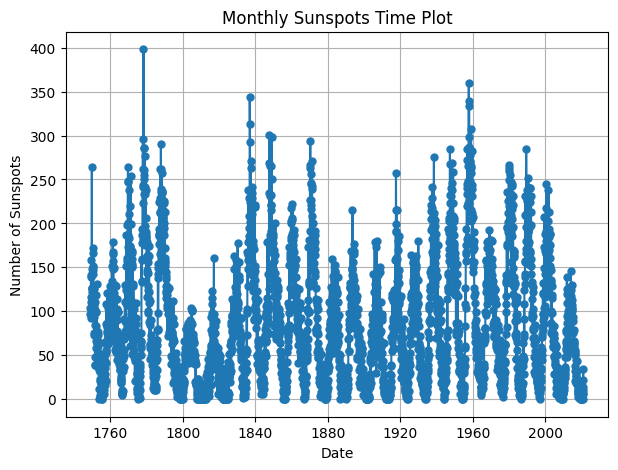

In [ ]:
# Time plot
plt.figure(figsize=(7, 5))
plt.plot(data.index, data['Sunspots'], marker='o', linestyle='-', markersize=5)
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.title('Monthly Sunspots Time Plot')
plt.grid(True)
plt.show()

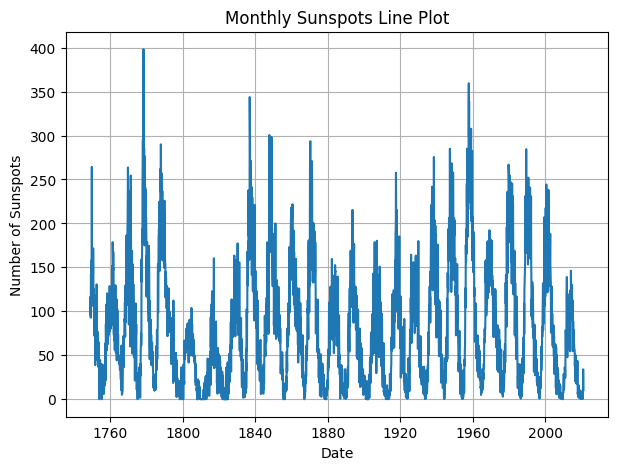

In [ ]:
# Line plot
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.plot(data)
plt.xlabel('Date')
plt.ylabel('Number of Sunspots')
plt.title('Monthly Sunspots Line Plot')
plt.grid(True)
plt.show()

<ipython-input-28-d5b8377b5158>:3: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x=data.index.month, y=data['Sunspots'], ci=None)


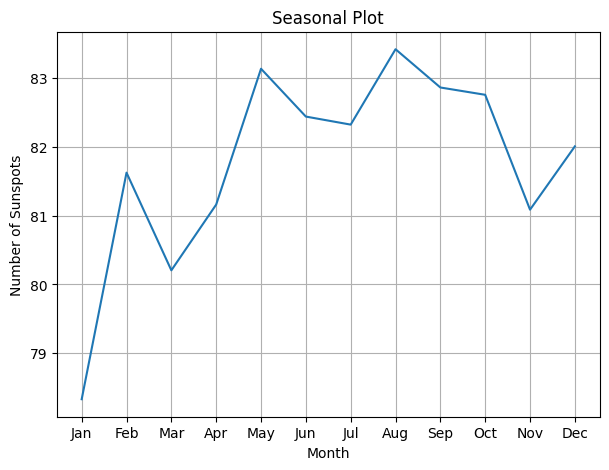

In [ ]:
# Seasonal plot
plt.figure(figsize=(7, 5))
sns.lineplot(x=data.index.month, y=data['Sunspots'], ci=None)
plt.xlabel('Month')
plt.ylabel('Number of Sunspots')
plt.title('Seasonal Plot')
plt.xticks(range(1, 13), labels=[
           'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.grid(True)
plt.show()

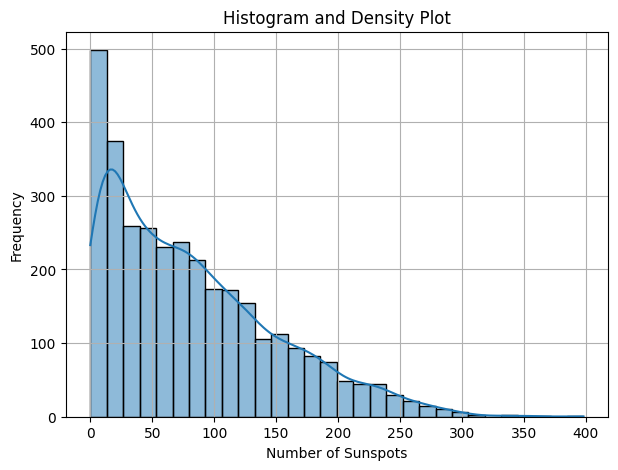

In [ ]:
# Histogram and Density Plot
plt.figure(figsize=(7, 5))
sns.histplot(data['Sunspots'], kde=True)
plt.xlabel('Number of Sunspots')
plt.ylabel('Frequency')
plt.title('Histogram and Density Plot')
plt.grid(True)
plt.show()

<Figure size 700x500 with 0 Axes>

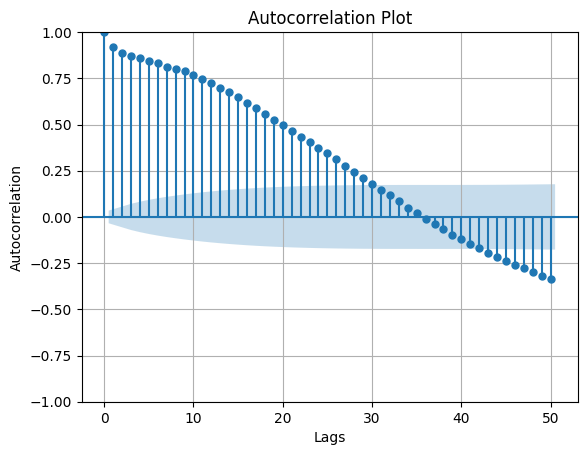

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrelation Plot
plt.figure(figsize=(7,5))
plot_acf(data['Sunspots'], lags=50)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot')
plt.grid(True)
plt.show()



<Figure size 700x500 with 0 Axes>

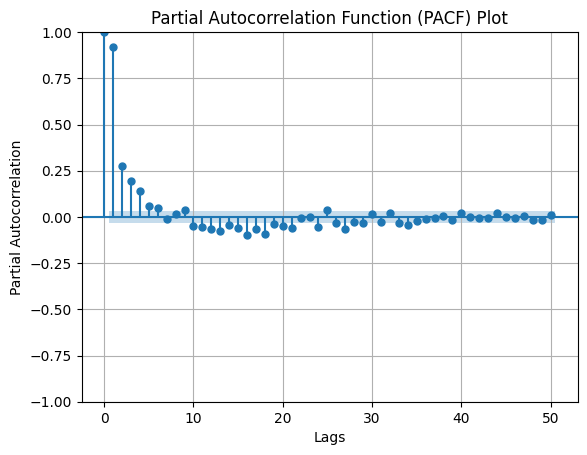

In [ ]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# PACF plot
plt.figure(figsize=(7, 5))
plot_pacf(data['Sunspots'], lags=50)
plt.xlabel('Lags')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Function (PACF) Plot')
plt.grid(True)
plt.show()

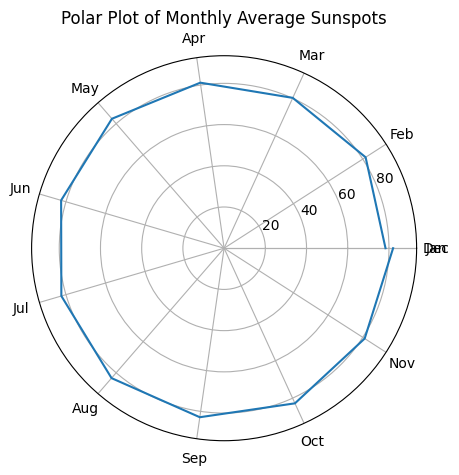

In [ ]:
# Extracting the month and year from the index of the above dataset "Monthly Sunspots"
data['Month_Num'] = data.index.month

# Grouping the data by month, calculating the average number of sunspots for each month
monthly_average = data.groupby('Month_Num')['Sunspots'].mean()

# Polar Plot theta (angle) and radii (length) settings
theta = np.linspace(0, 2 * np.pi, len(monthly_average))
radii = monthly_average.values

# Polar Plot
plt.figure(figsize=(7, 5))
plt.polar(theta, radii)
plt.title('Polar Plot of Monthly Average Sunspots')
plt.xticks(theta, ['Jan', 'Feb', 'Mar', 'Apr', 'May',
				'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

# Set y-axis limit to accommodate the data
plt.ylim(0, radii.max() + 10)
plt.show()


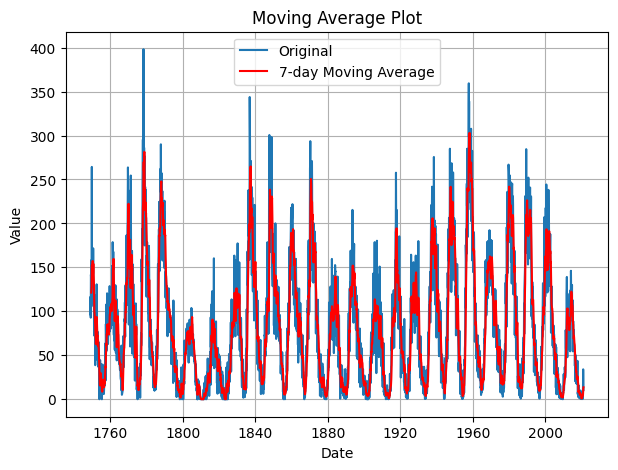

In [ ]:
# Moving Average Plot
plt.figure(figsize=(7, 5))
values = data['Sunspots']

# 7-day moving average
rolling_mean = values.rolling(window=7).mean()
plt.plot(values, label='Original')
plt.plot(rolling_mean, label='7-day Moving Average', color='red')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Moving Average Plot')
plt.legend()
plt.grid(True)
plt.show()


In [3]:
data.columns

Index(['Year', 'Month', 'Day', 'Number of Sunspots'], dtype='object')

In [10]:
group2 = data.groupby([data['Year'].astype(int),data['Month'].astype(int)]).mean()
group2['Year'] = group2['Year'].astype(int)
group2['Month'] = group2['Month'].astype(int)

group2['year_month'] = group2['Year'].astype(str) + '-' + group2['Month'].astype(str)

group2['year_month'] = pd.to_datetime(group2['year_month'], format='%Y-%m')
group2['year_month'] = group2['year_month'].dt.to_period('M')  # Converts to 'YYYY-MM' format without the day



sunspots = np.array(group2['Number of Sunspots'].astype(int))

time = group2['year_month'].values #np.arange(sunspots.size)
series = np.array(sunspots)

df_prophet = pd.DataFrame({'ds':time, 'y':series})
df_prophet['ds'] = df_prophet['ds'].astype('object')
df_prophet['ds'] = df_prophet['ds'].astype(str)

# Splitting the DataFrame into train and test DataFrames
df_train_prophet, df_data_test = train_test_split(df_prophet, test_size=0.2, shuffle = False)

df_data_test['ds'] = pd.to_datetime(df_data_test['ds'], format='%Y-%m')
"""
df_train_prophet = df_prophet[df_prophet['ds'] < '1975-01']
df_data_test = df_prophet[df_prophet['ds'] >= '1975-01']
"""

"\ndf_train_prophet = df_prophet[df_prophet['ds'] < '1975-01']\ndf_data_test = df_prophet[df_prophet['ds'] >= '1975-01']\n"

In [11]:
df_train_prophet.head()

,ds,y
0,1818-01,58
1,1818-02,65
2,1818-03,49
3,1818-04,57
4,1818-05,88


In [12]:
def prophet_model(df_train_prophet, df_data_test, growth='logistic', seasonality_mode='multiplicative', fourier_order=50,
                  changepoint_prior_scale=10, seasonality_prior_scale=10.0, holidays_prior_scale=10.0,
                  mcmc_samples=0, **kwargs):

    if growth=='logistic':
        # Using logistic growth
        df_train_prophet['cap'] = 0.95 * df_train_prophet['y'].max()
        df_train_prophet['floor'] = 1.05 * df_train_prophet['y'].min()

        model_prophet  = Prophet(growth=growth, seasonality_mode = seasonality_mode, changepoint_prior_scale=changepoint_prior_scale,
                                 seasonality_prior_scale=seasonality_prior_scale, holidays_prior_scale=holidays_prior_scale)
        model_prophet.add_seasonality(name='yearly', period=11*365, fourier_order=fourier_order)
        model_prophet.fit(df_train_prophet)

        df_future = model_prophet.make_future_dataframe(periods=df_data_test.shape[0], freq='MS')

        df_future['cap'] = 0.95 * df_train_prophet['y'].max()
        df_future['floor'] = 1.05 * df_train_prophet['y'].min()
        forecast_prophet = model_prophet.predict(df_future)
         #forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

        x_valid = df_data_test['y'].values
        results = forecast_prophet['yhat'].values[-df_data_test.shape[0]:]

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(x_valid, results))
        rmse = np.float64(rmse)

        # Compute the MAE
        mae_nn = tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()
        mae_nn = np.float64(mae_nn)

    return rmse, mae_nn

In [13]:
# Using logistic growth
df_train_prophet['cap'] = 0.95 * df_train_prophet['y'].max()
df_train_prophet['floor'] = 1.05 * df_train_prophet['y'].min()

model_prophet  = Prophet(growth='logistic', seasonality_mode='multiplicative', changepoint_prior_scale=25,
                         seasonality_prior_scale=0.25, holidays_prior_scale=1)
model_prophet.add_seasonality(name='yearly', period=11*365, fourier_order=50)

model_prophet.fit(df_train_prophet)

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc84u8q52/9si55fsh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpc84u8q52/acsfbz7b.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65008', 'data', 'file=/tmp/tmpc84u8q52/9si55fsh.json', 'init=/tmp/tmpc84u8q52/acsfbz7b.json', 'output', 'file=/tmp/tmpc84u8q52/prophet_modelz_9dzr_5/prophet_model-20241129171820.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:18:20 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:18:27 - cmdstanpy - INFO - Chain [1] do

In [14]:
# Directory for neural network runs

import datetime

current_dir = os.getcwd()
#if not os.path.exists(results_dir):
#    os.makedirs(results_dir)

results_dir = os.path.join(current_dir, 'results/prophet')
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# Generate a timestamp for the folder name
current_time = datetime.datetime.now()
folder_name = current_time.strftime("run_%Y-%m-%d_%H-%M-%S")

results_dir = os.path.join(results_dir, folder_name)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)

In [ ]:
df_future = model_prophet.make_future_dataframe(periods=df_data_test.shape[0], freq='MS')

df_future['cap'] = 0.95 * df_train_prophet['y'].max()
df_future['floor'] = 1.05 * df_train_prophet['y'].min()
forecast_prophet = model_prophet.predict(df_future)

forecast_prophet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].round().tail()

,ds,yhat,yhat_lower,yhat_upper
2386,2019-05-01,22.0,-60.0,103.0
2387,2019-06-01,23.0,-60.0,111.0
2388,2019-07-01,26.0,-64.0,124.0
2389,2019-08-01,24.0,-57.0,117.0
2390,2019-09-01,23.0,-60.0,108.0


<Figure size 1000x600 with 0 Axes>

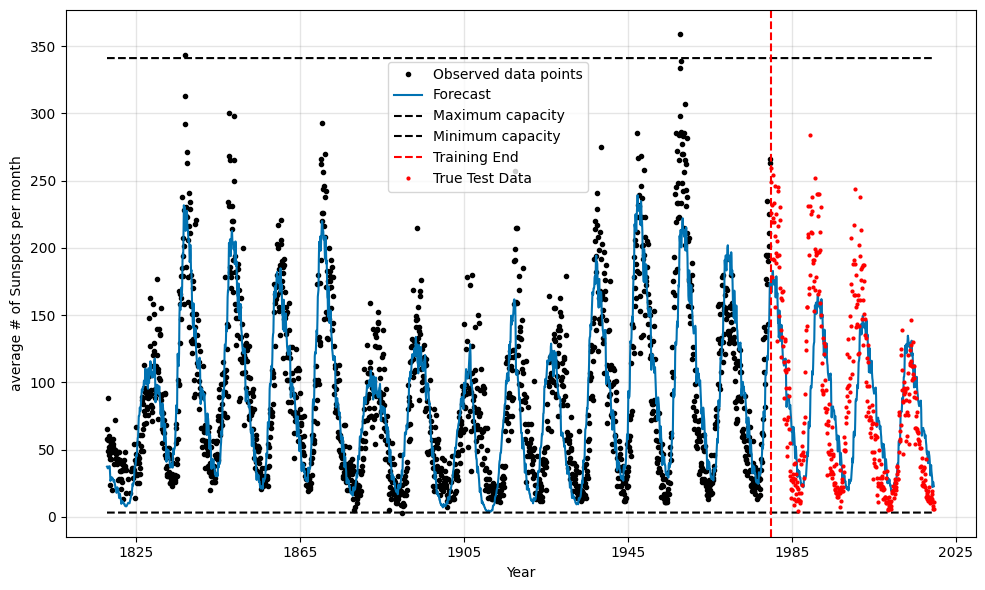

In [ ]:
import matplotlib.pyplot as plt

# plot the time series
fig = plt.figure(figsize=(10, 6))

forecast_plot = model_prophet.plot(forecast_prophet, uncertainty=False)

# add a vertical line at the end of the training period
axes = forecast_plot.gca()
# Change the axis labels
plt.xlabel("Year")
plt.ylabel("average # of Sunspots per month")

last_training_date = forecast_prophet['ds'].iloc[-df_data_test.shape[0]]
axes.axvline(x=last_training_date, color='red', linestyle='--', label='Training End')

# plot true test data for the period after the red line

#df_data_test['ds'] = df_data_test['ds'].dt.to_period('M')

#df_data_test['ds'] = pd.to_datetime(df_data_test['ds'])
#df_data_test['ds'] = df_data_test['ds'].dt.to_period('M')

plt.plot(df_data_test['ds'], df_data_test['y'],'ro', markersize=2, label='True Test Data')
# show the legend to distinguish between the lines
forecast_plot.legend(bbox_to_anchor=(0.6, 0.9))
forecast_plot.savefig(results_dir+'/predictions.png',\
           dpi=600,format='png',bbox_inches='tight')

plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
import json

x_valid = df_data_test['y'].values
results = forecast_prophet['yhat'].values[-df_data_test.shape[0]:]

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(x_valid, results))
rmse = np.float64(rmse)

# Print RMSE
print("Root Mean Square Error:", rmse)

import tensorflow as tf

# Compute MAE using TensorFlow
mae_nn = tf.reduce_mean(tf.abs(x_valid - results)).numpy()

# Print MAE
print("Mean Absolute Error =", mae_nn)



# Saving hyperparameters --------------------------------------
nn_performance = {
    'mae': mae_nn,
    'rmse': rmse
}

# Specify the file path for saving the JSON configuration
file_path = results_dir + '/performance.json'

with open(file_path, 'w') as f:
    json.dump(nn_performance, f, indent=2)

Root Mean Square Error: 51.893066344911176
Mean Absolute Error = 39.9481012633075
